In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

from simple_autodiff.engine import Tensor
from simple_autodiff.nn import MLP

np.random.seed(0)

In [2]:
# load MNIST dataset
X, y = fetch_openml('mnist_784', return_X_y=True, as_frame=False, parser='liac-arff')
X /= 255.
y = y.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y)

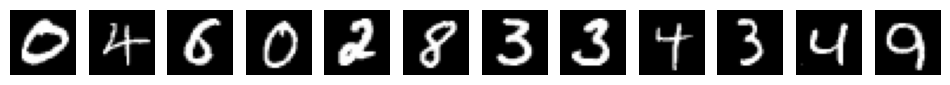

In [3]:
fig, ax = plt.subplots(1, 12, figsize=(12, 1), dpi=100)

for axis, idx in zip(fig.axes, np.random.randint(len(X_train), size=12)):
    axis.imshow(X_train[idx, :].reshape(28,28), cmap='gray')
    axis.axis('off')

In [4]:
# initialize a model 
model = MLP(X_train.shape[1], [100, 200, 10]) # 2-layer neural network
print(model)
print("number of parameters", sum(np.prod(p.data.shape) for p in model.parameters()))

MLP of [ReLU layer of width 100, ReLU layer of width 200, linear layer of width 10]
number of parameters 100710


In [5]:
# loss function
def loss(batch_size=None):
    
    # inline data loader
    if batch_size is None:
        Xb, yb = X_train, y_train
    else:
        ri = np.random.permutation(X_train.shape[0])[:batch_size]
        Xb, yb = X_train[ri], y_train[ri]
    
    # forward the model to get scores
    scores = model(Tensor(Xb))

    # compute cross entropy loss
    losses = scores.softmax_cross_entropy(yb)
    data_loss = losses.sum() / losses.data.shape[0]
    
    # add L2 regularization
    alpha = 1e-5
    reg_loss = alpha * sum(((p ** 2).sum() for p in model.parameters()))
    total_loss = data_loss + reg_loss
    
    # also get accuracy
    accuracy = np.mean(np.argmax(scores.data, axis=1) == yb)
    return total_loss, accuracy

total_loss, acc = loss()
print(total_loss, acc)

Tensor(data=[[2.38079935]], grad=[[0.]]) 0.07773333333333333


In [6]:
# optimization
steps = 10000
for k in range(steps):
    
    # forward
    total_loss, acc = loss(batch_size=32)
    
    # backward
    model.zero_grad()
    total_loss.backward()
    
    # update (sgd)
    learning_rate = 0.1 - 0.09 * k / steps
    for p in model.parameters():
        p.data -= learning_rate * p.grad
    
    if k % 500 == 0:
        print(f"step {k} loss {total_loss.data}, train acc {acc * 100}%")

test_scores = model(Tensor(X_test))
test_accuracy = np.mean(np.argmax(test_scores.data, axis=1) == y_test)
print(f"test acc {test_accuracy * 100}%")

step 0 loss [[2.5363774]], train acc 0.0%
step 500 loss [[0.09971595]], train acc 96.875%
step 1000 loss [[0.27920826]], train acc 90.625%
step 1500 loss [[0.06290742]], train acc 100.0%
step 2000 loss [[0.05844455]], train acc 100.0%
step 2500 loss [[0.06626381]], train acc 96.875%
step 3000 loss [[0.09145641]], train acc 100.0%
step 3500 loss [[0.08957333]], train acc 96.875%
step 4000 loss [[0.07337886]], train acc 96.875%
step 4500 loss [[0.19745989]], train acc 96.875%
step 5000 loss [[0.02265227]], train acc 100.0%
step 5500 loss [[0.02601511]], train acc 100.0%
step 6000 loss [[0.25233184]], train acc 96.875%
step 6500 loss [[0.03600287]], train acc 100.0%
step 7000 loss [[0.14350033]], train acc 96.875%
step 7500 loss [[0.01407039]], train acc 100.0%
step 8000 loss [[0.01927936]], train acc 100.0%
step 8500 loss [[0.13799338]], train acc 96.875%
step 9000 loss [[0.04869596]], train acc 96.875%
step 9500 loss [[0.02087491]], train acc 100.0%
test acc 97.45714285714286%
